# Gutzwiller in Kspace

The goal is to implement the slatter deteminant on a quantum computer by writing the manybody state in k-space and then fourier transforming to get the real space state vector.  I anticipate that their will be some subtlties with the fourier transorm so let us begin with the non-interacting states and work our way up.  

In [1]:
import qiskit.quantum_info as qi
import scipy as sp
import numpy as np
import pandas as pd
import math


def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

# Single Particle Wavefunction

We have $$ \hat{K} = k \sum_{i\sigma} \left( c^{\dagger}_{i\sigma}c_{i+1\sigma} + c^{\dagger}_{i+1\sigma}c_{i\sigma} \right)$$

This gives,
$$ |n> = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} e^{i \frac{2\pi n}{N} j}|j> $$
$$ E_n = -2k\cos\left(\frac{2\pi n}{N}\right)$$

In [2]:
def K(k,N):
    h = [[0 for i in range(N)] for ii in range(N)]
    h[0][N-1] = -k
    h[N-1][0] = -k
    for i in range(N-1):
        h[i][i+1] = -k
        h[i+1][i] = -k
    return h
#print(pd.DataFrame(K(k,N)))
      
#We know the eigenvalues and vectors
def E0(k,n,N):
    #return -2*k*np.cos((n+1)*np.pi/(N+1))
    return -2*k*np.cos(2*(n)*np.pi/(N))


def psi0(n,N):
    #y = [np.sqrt(2/(N+1))*np.sin((i+1)*(N-n)*np.pi/(N+1)) for i in range(N)]
    y = [np.sqrt(1/(N))*np.exp(1j*2*np.pi*(i)*(n)/N) for i in range(N)]
    return y

/opt/miniconda3/envs/qiskit_nick/lib/python3.9/site-packages/matplotlib/collections.py:202: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


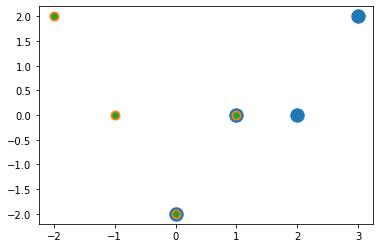

In [3]:
import matplotlib.pyplot as plt

k=1.0
N=4
e,y = np.linalg.eig(K(k,N))
e = np.sort(e)
nl = [n for n in range(len(e))]
etst = [E0(k,n,N) for n in range(-int(N/2),int(math.ceil(N/2)))]
etst2 = [bkt(psi0(n,N),K(k,N),psi0(n,N)) for n in range(-int(N/2),int(math.ceil(N/2)))]
ntst = [n for n in range(int(-N/2),int(math.ceil(N/2)))]
plt.scatter(nl,e,s=180)
plt.scatter(ntst,etst,s=80)
plt.scatter(ntst,etst2,s=30)

## Single Particle Fourier transform

We can diagonalize $\hat{K}$ using the fourier transform.

$$ \bar{K}_{nm} = <n|\hat{K}|m> = \frac{1}{N}\sum_{ij}e^{ik_n i}\hat{K}_{ij}e^{ik_mj} = -2k\cos\left(\frac{2\pi n}{N}\right) \delta_{nm}$$



In [4]:
def Kn(k,N):
    h = K(k,4)
    hn = []
    for n in range(N):
        hm = []
        for m in range(N):
            hnm = 0
            for i in range(N):
                for j in range(N):
                     hnm += (1/N)*np.exp(1j*2*np.pi*(i)*(n)/N)*h[i][j]*np.exp(1j*2*np.pi*(j)*(m)/N)
            hm.append(hnm)
        hn.append(hm)
    return hn

pd.DataFrame(Kn(1,4))

,0,1,2,3
0,-2.000000e+00+0.000000e+00j,5.551115e-17-8.612732e-17j,0.000000e+00-1.224647e-16j,-2.220446e-16-1.751152e-16j
1,9.184851e-17+0.000000e+00j,0.000000e+00+0.000000e+00j,9.756970e-17+1.110223e-16j,0.000000e+00+0.000000e+00j
2,0.000000e+00-1.224647e-16j,1.110223e-16+5.837175e-17j,2.000000e+00-7.347881e-16j,-1.665335e-16+2.028708e-16j
3,-1.645232e-16-2.220446e-16j,0.000000e+00+0.000000e+00j,-2.257556e-16+2.220446e-16j,-9.860761e-32+0.000000e+00j


# Many Body

In [5]:

def I(N):
    label = ['I' for i in range(N)]
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def c(i,N):
    label_1 = ['Z' for j in range(i)]
    label_2 = ['I' for j in range(i+1,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x+1j*y)

def cd(i,N):
    label_1 = ['Z' for j in range(i)]
    label_2 = ['I' for j in range(i+1,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x-1j*y)

import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

In [6]:
def Km(k,N):
    m = 0*I(N)
    for i in range(0,N-1):
        m = m + Mdot([cd(i,N),c(i+1,N)])+ Mdot([cd(i+1,N),c(i,N)])
    m = m + Mdot([cd(N-1,N),c(0,N)])+ Mdot([cd(0,N),c(N-1,N)])
    return m

$\hat{K}$ contains modes of the form 
$$ a^{\dagger}_n = \frac{1}{\sqrt{N}}\sum_{j=0}^{N}e^{i \frac{2\pi n}{N}j}c^{\dagger}_j $$

so that,
$$ \hat{K} \prod_{\{n\}}a^{\dagger}_n |0> = E_{\{n\}}|0>$$

In [7]:
def ad(n,N):
    out = cd(0,N)
    for i in range(1,N):
        out = out + np.exp(1j*2*np.pi*n*i/N)*cd(i,N)
    return 1/np.sqrt(N)*out

def a(n,N):
    out = c(0,N)
    for i in range(1,N):
        out = out + np.exp(-1j*2*np.pi*n*i/N)*c(i,N)
    return 1/np.sqrt(N)*out

In [8]:
def psi0(N):
    y = [0 for i in range(2**N)]
    y[-1] = 1
    return y


psi1 = Mdot([ad(2,4),ad(0,4),psi0(4)])
print('check normalization: ',Mdot([np.conjugate(psi1),psi1]))
print('check eigenvalue', np.amax(np.abs(Mdot([Km(1,4),psi1]) - bkt(psi1,Km(1,4),psi1)*psi1)) )

check normalization:  (1+0j)
check eigenvalue 1.224646799147353e-16


A general rotation between $\prod_i c^{\dagger}_i|0> \rightarrow \prod_n a^{\dagger}_n|0>$ where 
$$ a^{\dagger}_n = \sum_{i=0}^{N}f_{in} c^{\dagger}_i$$
can be generated by the Thouless operator
$$ T = e^{\sum_{in}\log(f)_{in}c^{\dagger}_nc_i} $$

We have to do the full expansion of the exponenation to see that this operator works.  To start notice that 
$$ T^{\dagger}|0> = e^{\log(f)_{in}c^{\dagger}_ic_n} |0> = |0> $$

Therefore, we can insert a $T^{\dagger}$ in
$$ T \prod_i c^{\dagger}_i |0> = \prod_i T c^{\dagger}_i T^{\dagger} |0> $$

Let $K = \sum_{in}\log(f)_{in}c^{\dagger}_nc_i $ we can evaluate 
$$ T c^{\dagger}_i T^{\dagger} = c^{\dagger}_i + \left[K, c^{\dagger}_i \right] + \frac{1}{2}\left[K, \left[K, c^{\dagger}_i \right] \right] + \ldots$$

The commutators are
$$ \left[K, c^{\dagger}_i \right] = \left[\sum_{jm}\log(f)_{jm}c^{\dagger}_mc_j , c^{\dagger}_i \right] = \sum_{m}\log(f)_{im}c^{\dagger}_m $$

Thus,
$$ T c^{\dagger}_i T^{\dagger} = \sum_{m} f(i,m)c^{\dagger}_m = a^{\dagger}_i$$

In [9]:
def f(i,n,N):
    return np.sqrt(1/(N))*np.exp(1j*2*np.pi*(i)*(n)/N)

def F(N): 
    return np.array([[f(i,n,N) for i in range(N)] for n in range(N)])

def logF(N):
    Fin = F(N)
    return np.pi/4*(I(2)-(1+1j)*Fin+Mdot([Fin,Fin])-(1-1j)*Mdot([Fin,Fin,Fin]))

def T(N):
    cMc = 0*I(N)
    for i in range(N):
        for j in range(N):
            cMc = cMc + logF(N)[i,j]*Mdot([cd(i,N),c(j,N)])
    return sp.linalg.expm(1j*cMc)



In [10]:
psi1 = Mdot([ad(0,4),ad(1,4),ad(3,4),psi0(4)])
psi1p = Mdot([cd(0,4),cd(1,4),cd(3,4),psi0(4)])
np.amax(np.abs( Mdot([T(N),psi1p])-psi1 ))

6.337625854564865e-16

$T(f)$ has the spacial property that $$ T(a)T(b) = T(ab) $$ Therefore, we can buld T(f) out of discrete rotations. 

For a stratagy see: https://arxiv.org/pdf/1711.04789.pdf or https://arxiv.org/pdf/1711.05395.pdf

The basic idea is to find a set of rotations which diagonalize $f$.  

In [11]:
def U(M):
    N = len(M)
    logM = sp.linalg.logm(M)
    cMc = 0*I(N)
    for i in range(N):
        for j in range(N):
            cMc = cMc + logM[i,j]*Mdot([cd(i,N),c(j,N)])
    return sp.linalg.expm(cMc)

def R(i,j,phi,N):
    return sp.linalg.expm( phi*(Mdot([cd(i,N),c(j,N)]) - Mdot([cd(j,N),c(i,N)]))  )

def r(i,j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[i,i] = np.cos(phi)
    M[j,j] = np.cos(phi)
    M[i,j] = np.sin(phi)
    M[j,i] = -np.sin(phi)
    return M

In [12]:
M=r(1,2,0.34,4)
np.amax(np.abs( U(M) - R(1,2,0.34,4) ))

1.0427989341167268e-16

In [13]:
def bd(M,n,N):
    out = M[0,n]*cd(0,N)
    for i in range(1,N):
        out = out + M[i,n]*cd(i,N)
    return out





In [14]:
Ma=F(4)
Mb=r(1,2,0.34,4)
M = Mdot([Mb,Ma])
np.amax(np.abs( Mdot([ U(M), cd(1,4) ,np.conjugate(np.transpose(U(M))) ]) - bd(M,1,4) ))
np.amax(np.abs( Mdot([ U(Ma),U(Mb), cd(1,4) ,np.conjugate(np.transpose(U(Mb))),np.conjugate(np.transpose(U(Ma))) ]) - bd(M,1,4) ))
np.amax(np.abs( Mdot([ U(Ma),U(Mb)]) - U(M) ))

3.738470343699757e-15

In [15]:
pd.DataFrame( F(4) )

,0,1,2,3
0,0.5+0.0j,0.5+0.0j,0.5+0.0j,0.5+0.0j
1,0.5+0.0j,0.0+0.5j,-0.5+0.0j,-0.0-0.5j
2,0.5+0.0j,-0.5+0.0j,0.5-0.0j,-0.5+0.0j
3,0.5+0.0j,-0.0-0.5j,-0.5+0.0j,0.0+0.5j


In [16]:
pd.DataFrame( r(0,3,0.4,4) )

,0,1,2,3
0,0.921061+0.000000j,0.0+0.0j,0.0+0.0j,0.389418+0.000000j
1,0.000000+0.000000j,1.0+0.0j,0.0+0.0j,0.000000+0.000000j
2,0.000000+0.000000j,0.0+0.0j,1.0+0.0j,0.000000+0.000000j
3,-0.389418+0.000000j,0.0+0.0j,0.0+0.0j,0.921061+0.000000j


## Let's find the rotations which diagonalize F

We use two types of rotations on the single particle space,

$$ (r^y_{ij}(\phi))_{kl} = \cos(\phi)\delta_{ik}\delta_{il}+\cos(\phi)\delta_{jk}\delta_{jl} + \sin(\phi)\delta_{ik}\delta_{jl} - \sin(\phi)\delta_{jk}\delta_{il}$$
and 
$$ (r^z_j(\phi))_{kl} = e^{i\phi}\delta_{ik}\delta_{kl} $$

we can use there to zero out each term in the matrix $F$.  Since $F$ is unitary we only have to zero out the bottom traingle and the upper triangle will automitically zero out.  Once we are done, we are left with a diagonal matrix $F_D$.  This can be obtained from a set of $r^z$ rotations (one for each diagonal entry).

Since $F$ is an $N \times N$ matrix.  We require $N^2/2$ steps to get to digaonalize F. 

In [17]:
def Mdot(Ol):
    L = len(Ol)
    out = Ol[L-1]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[L-1-i],out)
    return out

def ry(i,j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[i,i] = np.cos(phi)
    M[j,j] = np.cos(phi)
    M[i,j] = np.sin(phi)
    M[j,i] = -np.sin(phi)
    return M

def rz(j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[j,j] = np.exp(1j*phi)
    return M



In [18]:
def givens(i,j,F):
    phiz = 1j*np.log( F[j,i]/F[i,i] * np.abs(F[i,i])/np.abs(F[j,i]) )
    Fz =  Mdot([rz(j,phiz,4) , F])
    phi = np.arctan(Fz[j,i]/Fz[i,i])
    F_new = Mdot([ry(i,j,phi,4) , Fz])
    return F_new,phiz,phi

def g(i,j,phi,phiz):
    return Mdot([rz(j,-phiz,4),ry(i,j,-phi,4)])
    


F1,pz1,p1 = givens(0,3,F(4))
F2,pz2,p2 = givens(0,2,F1)
F3,pz3,p3 = givens(0,1,F2)
F4,pz4,p4 = givens(1,3,F3)
F5,pz5,p5 = givens(1,2,F4)
F6,pz6,p6 = givens(2,3,F5)
pd.DataFrame( F6 )

,0,1,2,3
0,1.000000e+00+0.000000e+00j,1.530808e-17+8.326673e-17j,0.000000e+00+6.123234e-17j,1.463720e-16+5.551115e-17j
1,-8.294989e-18-5.361965e-17j,5.468656e-18+1.000000e+00j,-1.302706e-16+8.989670e-17j,-3.367610e-17+2.163368e-17j
2,-5.246212e-18+1.573864e-17j,-4.644396e-17-3.405807e-18j,3.162278e-01-9.486833e-01j,-2.393954e-16+2.070996e-16j
3,-3.880778e-17+3.791873e-17j,-2.937374e-17+2.007192e-17j,-5.129048e-17+1.806368e-16j,6.000000e-01-8.000000e-01j


In [19]:
np.amax(np.abs(  Mdot([g(0,3,p1,pz1),g(0,2,p2,pz2),g(0,1,p3,pz3),g(1,3,p4,pz4),g(1,2,p5,pz5),g(2,3,p6,pz6),F6]) - F(4)  ))


2.22240502577538e-16

## Now let's translate these rotations into Thouless operators to generate the many body state

$$ T(r^z_j(\phi)) = e^{i\phi c^{\dagger}_jc_j} $$

$$ T(r^y_{ij}(\phi)) = e^{\phi (c^{\dagger}_ic_j - c^{\dagger}_jc_i)} $$

In [20]:
def Ry(i,j,phi,N):
    return sp.linalg.expm(phi*(Mdot([cd(i,N),c(j,N)]) - Mdot([cd(j,N),c(i,N)]))  )

def ry(i,j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[i,i] = np.cos(phi)
    M[j,j] = np.cos(phi)
    M[i,j] = np.sin(phi)
    M[j,i] = -np.sin(phi)
    return M

def Rz(j,phi,N):
    return sp.linalg.expm(1j*phi*Mdot([cd(j,N),c(j,N)])   )

def rz(j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[j,j] = np.exp(1j*phi)
    return M



In [21]:
My=ry(1,2,0.34,4)
Mz=rz(2,0.76,4)
M = Mdot([My,Mz])
np.amax(np.abs( Mdot([ U(M), cd(1,4) ,np.conjugate(np.transpose(U(M))) ]) - bd(M,1,4) ))
np.amax(np.abs( Mdot([ Rz(2,0.76,4), cd(1,4) ,np.conjugate(np.transpose(Rz(2,0.76,4))) ]) - bd(M,1,4) ))
np.amax(np.abs( Mdot([ Ry(1,2,0.34,4), cd(1,4) ,np.conjugate(np.transpose(Ry(1,2,0.34,4))) ]) - bd(M,1,4) ))
np.amax(np.abs( Mdot([Ry(1,2,0.34,4), Rz(2,0.76,4), cd(1,4),np.conjugate(np.transpose(Rz(2,0.76,4))) ,np.conjugate(np.transpose(Ry(1,2,0.34,4))) ]) - bd(M,1,4) ))



2.2243064008712035e-16

In [22]:
def Ry_gate(i,j,phi,N):
    Zchain = Mdot([I(4)]+[Z(l,N) for l in range(i+1,j)])
    g1 = sp.linalg.expm(1j*phi/2*Mdot([X(i,N),Zchain,Y(j,N)]) )
    g2 = sp.linalg.expm(-1j*phi/2* Mdot([Y(i,N),Zchain,X(j,N)]) )
    return Mdot([g1,g2])

def Rz_gate(j,phi,N):
    return np.exp(1j*phi/2)*sp.linalg.expm(-1j*phi/2*Z(j,N))




In [23]:
i=1
j=3
phi = 1.27
print( np.amax(np.abs( Ry_gate(i,j,phi,N) - Ry(i,j,phi,N) )) )
print( np.amax(np.abs( Rz_gate(j,phi,N) - Rz(j,phi,N) )) )

2.220446049250313e-16
2.2887833992611187e-16


In [24]:
def G(i,j,phi,phiz,N):
    out = Mdot([Rz_gate(j,-phiz,N),Ry_gate(i,j,-phi,N)])
    return out

In [25]:
ph0 = -1j*np.log(F6[0,0])
ph1 = -1j*np.log(F6[1,1])
ph2 = -1j*np.log(F6[2,2])
ph3 = -1j*np.log(F6[3,3])
u0 = Mdot([Rz_gate(0,ph0,4),Rz_gate(1,ph1,4),Rz_gate(2,ph2,4),Rz_gate(3,ph3,4)])
ua = G(2,3,p6,pz6,4)
ub = G(1,2,p5,pz5,4)
uc = G(1,3,p4,pz4,4)
ud = G(0,1,p3,pz3,4)
ue = G(0,2,p2,pz2,4)
uf = G(0,3,p1,pz1,4)
np.amax(np.abs( Mdot([uf,ue,ud,uc,ub,ua,u0]) - U(F(4)) ))

1.0578003994148167e-15

In [26]:
def psi0(N):
    y = [0 for i in range(2**N)]
    y[0] = 1
    return y

psi1 = Mdot([ad(0,4),ad(1,4),ad(3,4),psi0(4)])
psi1p = Mdot([cd(0,4),cd(1,4),cd(3,4),psi0(4)])
np.amax(np.abs( Mdot([Mdot([uf,ue,ud,uc,ub,ua,u0]),psi1p])-psi1 ))

5.291975941026304e-16

## Now Let us do this using quantum gates

In [27]:
def I(N):
    label = ['I' for i in range(N)]
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def X(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def c(i,N):
    label_1 = ['Z' for j in range(N-i-1)]
    label_2 = ['I' for j in range(N-i,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x+1j*y)

def cd(i,N):
    label_1 = ['Z' for j in range(N-i-1)]
    label_2 = ['I' for j in range(N-i,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x-1j*y)

def Ry_gate(i,j,phi,N):
    Zchain = Mdot([I(4)]+[Z(l,N) for l in range(i+1,j)])
    g1 = sp.linalg.expm(1j*phi/2*Mdot([X(i,N),Zchain,Y(j,N)]) )
    g2 = sp.linalg.expm(-1j*phi/2* Mdot([Y(i,N),Zchain,X(j,N)]) )
    return Mdot([g1,g2])

def Rz_gate(j,phi,N):
    return np.exp(1j*phi/2)*sp.linalg.expm(-1j*phi/2*Z(j,N))

Using Jordan-Wigner we have a simple transformation for the $r^z$ rotation,

$$ T(r^z_{j}(\phi)) = R^z_j(\phi/2) $$

The $r^y$ rotation is a little more involved,

$$ T(r^y_{ij}(\phi)) = e^{i \phi/2 X_i Z_{i+1}\ldots Z_{j-1}Y_j} e^{-i \phi/2 Y_i Z_{i+1}\ldots Z_{j-1}X_j} $$

The goal is to implement this by first swapping the sites so that $j=i+1$ then we can apply,

$$ T(r^y_{ij}(\phi)) =  [\text{fSWAPS}] R^{XY}_{i,i+1}(\phi/4)R^{YX}_{i,i+1}(-\phi/4) [\text{fSWAPS}] $$

There is a subtlety here that we cannot just use normal swaps.  We have to use fermion swaps which applys a negetive sign with both sites are filled. 

We see that this can be performed with a normal swap fallowed by $\sqrt{Y}C^x\sqrt{-Y}$

$R^{XY}$ and $R^{YX}$ each contain 2 $C^x$ gates.  A normal swap contains 3 $C^x$ gates, so a fermion swap contains 4.  The furthest away two sites can be is $N$.  So the number of $C^x$ gates in each $T$ is less than 2N+4.  We need $N^2/2$ applications of $T$ to diagonalize $F$.  So the total number of $C^x$ gates is less than 

$$ N_{C^x} < N^3+2N^2 $$

In [28]:
from qiskit import QuantumCircuit

def fswap(i,j,qc):
    qc.swap(i,j)
    qc.ry(np.pi/2,j)
    qc.cx(i,j)
    qc.ry(-np.pi/2,j)
    return qc
    

def R_cc(i,j,phi,qc):
    for l in range(i+1,j):
        qc = fswap(l-1,l,qc)
    qc.ry(-np.pi/2,j-1)
    qc.cx(j-1,j)
    qc.ry(-phi,j)
    qc.cx(j-1,j)
    qc.ry(np.pi/2,j-1)
    qc.ry(-np.pi/2,j)
    qc.cx(j,j-1)
    qc.ry(phi,j-1)
    qc.cx(j,j-1)
    qc.ry(np.pi/2,j)
    for l in range(j-1,i+1-1,-1):
        qc = fswap(l-1,l,qc)
    return qc

def G_cc(i,j,phi,phiz,qc):
    qc = R_cc(i,j,-phi,qc)
    qc.rz(-phiz,j)
    return qc

qc = QuantumCircuit(4)
qc = G_cc(0,3,0.34,0.11,qc)
qc.draw()

»
q_0: ─X──────────────■─────────────────────────────────────────────────────────»
      │ ┌─────────┐┌─┴─┐┌──────────┐                                           »
q_1: ─X─┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├─X──────────────■──────────────────────────»
        └─────────┘└───┘└──────────┘ │ ┌─────────┐┌─┴─┐┌──────────┐┌──────────┐»
q_2: ────────────────────────────────X─┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├┤ Ry(-π/2) ├»
                                       └─────────┘└───┘└──────────┘└──────────┘»
q_3: ──────────────────────────────────────────────────────────────────────────»
                                                                               »
«                                                                         »
«q_0: ────────────────────────────────────────────────────────────────────»
«                                                                         »
«q_1: ──────────────────────────────────────────────────────────────X─────»
«                           ┌─────────┐ ┌───┐┌───────────┐┌───┐     │     »
«q_2: ──■────────────────■──┤ Ry(π/2) ├─┤ X ├┤ Ry(-0.34) ├┤ X ├─────X─────»
«     ┌─┴─┐┌──────────┐┌─┴─┐├─────────┴┐└─┬─┘└───────────┘└─┬─┘┌─────────┐»
«q_3: ┤ X ├┤ Ry(0.34) ├┤ X ├┤ Ry(-π/2) ├──■─────────────────■──┤ Ry(π/2) ├»
«     └───┘└──────────┘└───┘└──────────┘                       └─────────┘»
«                                                               
«q_0: ───────────────────────X───────────────────■──────────────
«                            │      ┌─────────┐┌─┴─┐┌──────────┐
«q_1: ───────────────■───────X──────┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├
«      ┌─────────┐ ┌─┴─┐┌──────────┐└─────────┘└───┘└──────────┘
«q_2: ─┤ Ry(π/2) ├─┤ X ├┤ Ry(-π/2) ├────────────────────────────
«     ┌┴─────────┴┐└───┘└──────────┘                            
«q_3: ┤ Rz(-0.11) ├─────────────────────────────────────────────
«     └───────────┘

In [29]:
qc = QuantumCircuit(4)
qc.x(0)
qc.x(1)
qc.rz(np.real(ph0),0)
qc.rz(np.real(ph1),1)
qc.rz(np.real(ph2),2)
qc.rz(np.real(ph3),3)
qc = G_cc(2,3,np.real(p6),np.real(pz6),qc)
qc = G_cc(1,2,np.real(p5),np.real(pz5),qc)
qc = G_cc(1,3,np.real(p4),np.real(pz4),qc)
qc = G_cc(0,1,np.real(p3),np.real(pz3),qc)
qc = G_cc(0,2,np.real(p2),np.real(pz2),qc)
qc = G_cc(0,3,np.real(p1),np.real(pz1),qc)
psi_tst = qi.Statevector.from_instruction(qc).data

u0 = Mdot([Rz_gate(0,ph0,4),Rz_gate(1,ph1,4),Rz_gate(2,ph2,4),Rz_gate(3,ph3,4)])
ua = G(2,3,p6,pz6,4)
ub = G(1,2,p5,pz5,4)
uc = G(1,3,p4,pz4,4)
ud = G(0,1,p3,pz3,4)
ue = G(0,2,p2,pz2,4)
uf = G(0,3,p1,pz1,4)
phase = np.exp(-1j*ph0/2)*np.exp(-1j*ph1/2)*np.exp(-1j*ph2/2)*np.exp(-1j*ph3/2)
phase = phase*np.exp(1j*pz6/2)*np.exp(1j*pz5/2)*np.exp(1j*pz4/2)*np.exp(1j*pz3/2)*np.exp(1j*pz2/2)*np.exp(1j*pz1/2)
np.amax(np.abs( phase*Mdot([uf,ue,ud,uc,ub,ua,u0,cd(1,4),cd(0,4),psi0(4)]) - psi_tst ))



2.830524433501838e-16

In [30]:
#qc.draw()

In [31]:
psi1 = Mdot([ad(1,4),ad(0,4),psi0(4)])
np.amax(np.abs( psi_tst - phase*psi1 ))

3.0103076614886674e-16

Okay so at long last, we have formed the Slatter determinent usinging quantum gates!

# Gutzwiller rotation

Now let us apply the Gutzwiller rotation $e^{-g\hat{D}}$ where
$$ \hat{D} = \sum_i \hat{n}_{i,\uparrow}\hat{n}_{i,\downarrow}  $$

The Gutzwiller approach is to generate the eigenvector of the full Hamiltonian $ |\psi> $ from the eigenvector of the non-interacting Hamiltoniain $ |\psi_0> $ via
$$ |\psi> = \frac{e^{-g\hat{D}}|\psi_0>}{\sqrt{<\psi_0|e^{-2g\hat{D}}|\psi_0>}}$$

The idea is to then break up the exponential in small setps $dg$ such taht $N_g dg = g$.
$$ e^{-g\hat{D}} = \prod_{i=1}^N e^{-g \hat{n}_{i\uparrow}\hat{n}_{i\downarrow}}  $$
Since $\hat{D}$ is diagonal, this is exact.  Using J-W we have,
$$ e^{-g\hat{D}}  \rightarrow \prod_{i=1}^N e^{-\frac{g}{4} (I -Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow})} $$
$$ = \prod_{i=1}^N (\cosh(\frac{g}{4})-\sinh(\frac{g}{4}))(\cosh(\frac{g}{4})+\sinh(\frac{g}{4})Z_{i\uparrow})(\cosh(\frac{g}{4})+\sinh(\frac{g}{4})Z_{i\downarrow})(\cosh(\frac{g}{4})-\sinh(\frac{g}{4})Z_{i\uparrow}Z_{i\downarrow}) $$
$$ = \prod_{i=1}^N \left( (C^4 - C^3S + C^2S^2 - C S^3 + S^4)I + (2C^2S^2 - C^3S - CS^3)(-Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow}) \right)$$

## Not using quantum gates

Let's strat by reminding ourselves how Gutzwiller works without worrying about writing things in terms of gates.

In [32]:
def Ks(N):
    I0 = np.identity(len(Km(1,N)))
    return np.kron(Km(1,N),I0) + np.kron(I0,Km(1,N))

def Ds(N):
    out = 0*I(2*N)
    for i in range(N):
        out = out + Mdot([cd(i,2*N),c(i,2*N),cd(i+N,2*N),c(i+N,2*N)])
    return out

def Hs(k,d,N):
    return k*Ks(N) + d*Ds(N)

def Gz(g,N):
    out = I(2*N)
    C = np.cosh(g/4)
    S = np.sinh(g/4)
    a = (C**4 - C**3*S  - C*S**3 + S**4)
    b = (- C**3*S + C**2*S**2 + C**2*S**2 - C*S**3)
    for i in range(N):
        out = Mdot([  out, a*I(2*N) + b*( -Z(i,2*N) - Z(i+N,2*N) + Mdot([Z(i,2*N),Z(i+N,2*N)]) ) ]) 
    return out
        
np.amax(np.abs( sp.linalg.expm(-Ds(4)) - Gz(1,4) ))

8.881784197001252e-16

In [33]:
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
psi_spin = np.kron(psi1,psi1)

print('eigenvalue is: ',bkt(psi_spin,Ks(4),psi_spin))
print('check if eigenstate: ', np.amax(np.abs( bkt(psi_spin,Ks(4),psi_spin)*psi_spin - Mdot([Ks(4),psi_spin]) )) )


eigenvalue is:  (-4+5.551115123125786e-17j)
check if eigenstate:  2.482534153247273e-16


/opt/miniconda3/envs/qiskit_nick/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


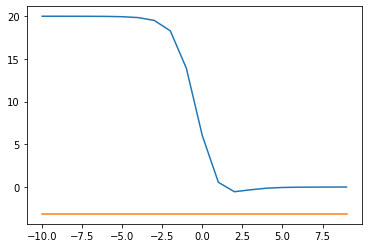

In [34]:
H = Hs(1,10,4)
e,y = np.linalg.eig(H)
y = np.transpose(y)
arg = np.argsort(e)
e = np.sort(e)


eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    #expD = sp.linalg.expm(-g*Ds(4))
    expD = Gz(g,4)
    psi = Mdot([expD,psi_spin])
    psi = psi/np.sqrt(Mdot([np.conjugate(psi),psi]))
    egl = bkt(psi,H,psi)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])

plt.plot(gl,eg)
plt.plot(gl,eT)
#print(e)

## Seperate into blocks

First we need everything in terms of Pauli matrices.  We already have $\hat{D}$,
$$ \hat{D} = \sum_i (I -Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow})$$

We can also write $\hat{K}$ in terms of Paulis
$$ \hat{K} = \sum_{\sigma}\sum_{i=0}^{N-2}(X_{i\sigma}X_{i+1\sigma}+Y_{i\sigma}Y_{i+1\sigma}) + \sum_{\sigma}(X_{0\sigma}\left(\prod_{j=1}^{N-2}Z_{j\sigma}\right)X_{N\sigma} +  Y_{0\sigma}\left(\prod_{j=1}^{N-2}Z_{j\sigma}\right)Y_{N\sigma} )$$


In [35]:
def Kmp(k,N):
    m = 0*I(N)
    for i in range(0,N-1):
        m = m + Mdot([X(i,N),X(i+1,N)])+ Mdot([Y(i+1,N),Y(i,N)])
    m = m + Mdot([X(N-1,N),Mdot([Z(j,N) for j in range(1,N-1)]),X(0,N)])+ Mdot([Y(0,N),Mdot([Z(j,N) for j in range(1,N-1)]),Y(N-1,N)])
    return 1/2*m

def Km(k,N):
    m = 0*I(N)
    for i in range(0,N-1):
        m = m + Mdot([cd(i,N),c(i+1,N)])+ Mdot([cd(i+1,N),c(i,N)])
    m = m + Mdot([cd(N-1,N),c(0,N)])+ Mdot([cd(0,N),c(N-1,N)])
    return m

np.amax(np.abs( Km(1,4) - Kmp(1,4) ))

0.0

We also need the Gutzwiller rotation in terms of Paulis which we have as,
$$ \hat{G}= \prod_{i=0}^{N-1}\left((C^4 - C^3S + C^2S^2 - C S^3 + S^4)I + (2C^2S^2 - C^3S - CS^3)(-Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow})\right)$$

We now need to find $\hat{G}(k\hat{K}+d\hat{D})\hat{G}$.  This could be done analytically but let's do it numerically for now.

In [36]:
import copy

def GHG(g,k,d,N):
    return Mdot([Gz(g,N),Hs(k,d,N),Gz(g,N)])

def norm(g,N):
    return Mdot([Gz(g,N),Gz(g,N)])

def find_blocks(O,N):
    bL = 2**N
    H_tu = O
    blocks = {}
    for bi in range(bL):
        for bj in range(bi,bL):
            bij = [[H_tu[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
            blocks[str(bi) + ',' + str(bj)] = np.array(bij)
    return blocks

def find_sets(psi,N):
    bL = 2**N
    sets = {}
    for bi in range(bL):
        psi_i = [psi[i + bL*bi] for i in range(0,bL)]
        sets[str(bi)] = np.array(psi_i)
    return sets

def G_blocks(g,N):
    return find_blocks(Gz(g,N),N)

def H_blocks(k,d,N):
    return find_blocks(Hs(k,d,N),N)
            
            
def GHG_blocks(g,k,d,N):
    return find_blocks(GHG(g,k,d,N),N)

def norm_blocks(g,N):
    return find_blocks(norm(g,N),N)



def psi_sets(N):
    return find_sets(psi_spin,N)

def Bdot(M,Psi):
    bL = len(Psi)
    out = copy.deepcopy(Psi)
    for bi in range(bL):
        out[str(bi)] = Mdot([M[str(bi) + ',' + str(bi)],Psi[str(bi)]])
    for bi in range(bL):
        for bj in range(bi+1,bL):
            out[str(bi)] = out[str(bi)] + Mdot([M[str(bi) + ',' + str(bj)],Psi[str(bj)]])
            out[str(bj)] = out[str(bj)] + Mdot([np.conjugate(M[str(bi) + ',' + str(bj)]),Psi[str(bi)]])
    return out

def Bdot2(Psi1,Psi2):
    bL = len(Psi1)
    out = 0
    for bi in range(bL):
        out += Mdot([np.conjugate(Psi1[str(bi)]),Psi2[str(bi)]])
    return out

def compare_sets(seta,setb):
    out = 0
    ka = seta.keys()
    kb = seta.keys()
    if ka == kb:
        for k in ka:
            out += np.amax(np.abs(seta[k]-setb[k]))
    else:
        return 'keys are different'
    return out

GHGpsi = Bdot(GHG_blocks(1,1,10,4),psi_sets(4))
Mdot([np.conjugate(psi_spin),GHG(1,1,10,4),psi_spin]) - Bdot2(psi_sets(4),GHGpsi)

1.850014188630019e-17j

In [37]:
g=2
k=1
d=10

expD = Gz(g,N)
psi = Mdot([expD,psi_spin])
psi = psi/np.sqrt(Mdot([np.conjugate(psi),psi]))
egl1 = bkt(psi,Hs(k,d,N),psi)

psi_g = Bdot(G_blocks(g,N),psi_sets(N))
norm2 = 1/np.sqrt(Bdot2(psi_g,psi_g))
Hpsi_g = Bdot(H_blocks(k,d,N),psi_g)
egl2 = norm2**2*Bdot2(psi_g,Hpsi_g)

print(egl1-egl2)

(-2.220446049250313e-16-1.8681319025814155e-17j)


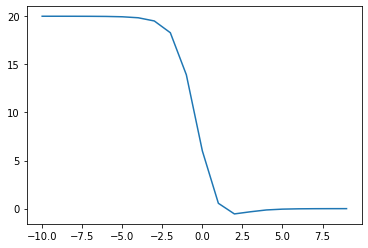

In [38]:
eg = []
eT = []
gl = []
for gi in range(-10,10):
    g = gi
    psi_g = Bdot(G_blocks(g,4),psi_sets(4))
    norm_i = 1/np.sqrt(Bdot2(psi_g,psi_g))
    Hpsi_g = Bdot(H_blocks(1,10,4),psi_g)
    egl = norm_i**2*Bdot2(psi_g,Hpsi_g)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])
    
plt.plot(gl,eg)

## Using Pauli Matrices

In [39]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.opflow.list_ops import SummedOp

In [40]:
def find_paulis(blocks):
    keys = list(blocks.keys())
    paulis = {}
    for key in keys:
        if np.amax(np.abs(blocks[key])) > 10**(-8):
            paulis[key] = MatrixOp(blocks[key]).to_pauli_op()
            if type(paulis[key]) is not SummedOp:
                paulis[key] = [paulis[key]]
    return paulis

#The off diagonal double is turned off since I keep all blocks
def bkt_paulis(psi1,O,psi2):
    keys = list(O.keys())
    out = 0
    for key in keys:
        key_split = key.split(',')
        for pauli in O[key]:
            p = pauli.primitive.to_label()
            P = qi.Operator.from_label(p).data
            w = pauli.coeff
            if key_split[0] == key_split[1]:
                out += w*Mdot([np.conjugate(psi1[key_split[0]]) , P , psi2[key_split[1]] ])
            else:
                out += w*Mdot([np.conjugate(psi1[key_split[0]]) , P , psi2[key_split[1]] ])
                out += w*np.conjugate( Mdot([ np.conjugate(psi1[key_split[0]]), P , psi2[key_split[1]] ]) )
    return out

In [41]:
def GHG_paulis(g,k,d,N):
    return find_paulis(GHG_blocks(g,k,d,N))

def norm_paulis(g,N):
    return find_paulis(norm_blocks(g,N))

In [42]:
g=2
k=1
d=10
N=4
print( np.amax(np.abs(norm_paulis(g,N)['1,1'].to_matrix() - norm_blocks(g,N)['1,1'])) )
print( np.amax(np.abs(GHG_paulis(g,k,d,N)['1,2'].to_matrix() - GHG_blocks(g,k,d,N)['1,2'])) )

1.734723475976807e-17
1.3877787807814457e-16


In [43]:
g=2
N=4
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
psi_spin = np.kron(psi1,psi1)
norm0 = 1/np.sqrt(Mdot([np.conjugate(psi_spin),norm(g,N),psi_spin]))

psi_g = Bdot(G_blocks(g,N),psi_sets(N))
norm1 = 1/np.sqrt(Bdot2(psi_g,psi_g))

norm2 = 1/np.sqrt( bkt_paulis(psi_sets(4),norm_paulis(g,N),psi_sets(4)) )
print(norm0,norm1,norm2)

(2.24162189942428+1.0359211144934273e-18j) (2.2416218994242794+0j) (2.2416218994242794+0j)


In [44]:
ghg1 = bkt(psi_spin,GHG(g,k,d,N),psi_spin)
ghg2 = bkt_paulis(psi_sets(N),GHG_paulis(g,k,d,N),psi_sets(N)) 
print(ghg1,ghg2)

(-0.1093059640994295-2.452201406808581e-18j) (-0.10930596409942947+0j)


In [45]:
def find_energy_paulis(g,k,d,N):
    psi =  psi_sets(N)
    GHG = GHG_paulis(g,k,d,N)
    norm = norm_paulis(g,N)
    e = bkt_paulis(psi,GHG,psi)/bkt_paulis(psi,norm,psi)
    return e

In [46]:
g=2
k=1
d=10

expD = Gz(g,N)
psi = Mdot([expD,psi_spin])
psi = psi/np.sqrt(Mdot([np.conjugate(psi),psi]))
egl1 = bkt(psi,Hs(k,d,N),psi)

egl2 = find_energy_paulis(g,k,d,N)

print(egl1,egl2)

(-0.5492481220964371-1.7275521802509475e-17j) (-0.5492481220964368+0j)


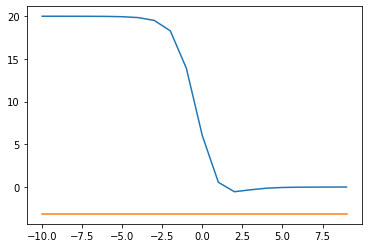

In [47]:
k=1
d=10
N=4
H = Hs(k,d,N)
e,y = np.linalg.eig(H)
e = np.sort(e)

eg = []
eT = []
gl = []
for gi in range(-10,10):
    g = gi
    egl = find_energy_paulis(g,k,d,N)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])

plt.plot(gl,eg)
plt.plot(gl,eT)

## Using Quantum Gates

In [48]:
#Finds the collection of unique Pauli terms
def pauli_collection(Ops):
    out = {}
    for O in Ops:
        keys = list(O.keys())
        for key in keys:
            block = O[key]
            for p in block:
                pauli = p.primitive.to_label()
                if pauli not in out:
                    out[pauli] = 0
    return out

paulis = pauli_collection([GHG_paulis(2,1,10,4),norm_paulis(2,4)])

In [49]:
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister, execute

def slatter_circ(F):
    F1,pz1,p1 = givens(0,3,F)
    F2,pz2,p2 = givens(0,2,F1)
    F3,pz3,p3 = givens(0,1,F2)
    F4,pz4,p4 = givens(1,3,F3)
    F5,pz5,p5 = givens(1,2,F4)
    F6,pz6,p6 = givens(2,3,F5)
    ph0 = -1j*np.log(F6[0,0])
    ph1 = -1j*np.log(F6[1,1])
    ph2 = -1j*np.log(F6[2,2])
    ph3 = -1j*np.log(F6[3,3])
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr , cr)
    qc.x(2)
    qc.x(3)
    qc.rz(np.real(ph0),0)
    qc.rz(np.real(ph1),1)
    qc.rz(np.real(ph2),2)
    qc.rz(np.real(ph3),3)
    qc = G_cc(2,3,np.real(p6),np.real(pz6),qc)
    qc = G_cc(1,2,np.real(p5),np.real(pz5),qc)
    qc = G_cc(1,3,np.real(p4),np.real(pz4),qc)
    qc = G_cc(0,1,np.real(p3),np.real(pz3),qc)
    qc = G_cc(0,2,np.real(p2),np.real(pz2),qc)
    qc = G_cc(0,3,np.real(p1),np.real(pz1),qc)
    return qc

#Test
qc = slatter_circ(F(4))
psi_tst = qi.Statevector.from_instruction(qc).data
phase = np.exp(-1j*ph0/2)*np.exp(-1j*ph1/2)*np.exp(-1j*ph2/2)*np.exp(-1j*ph3/2)
phase = phase*np.exp(1j*pz6/2)*np.exp(1j*pz5/2)*np.exp(1j*pz4/2)*np.exp(1j*pz3/2)*np.exp(1j*pz2/2)*np.exp(1j*pz1/2)
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
np.amax(np.abs( psi_tst - phase*psi1 ))


2.187358838057016e-16

In [50]:
def create_circ(p_label):
    qbits = [0,1,2,3]
    qc = slatter_circ(F(4))
    psi = copy.deepcopy(qc)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)-1
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    psi.measure(psi.qubits,psi.clbits)
    return [psi,pauli_qs,p_label]

def create_circs(paulis):
    keys = list(paulis.keys())
    circs = []
    meas = []
    labels = []
    for key in keys:
        ck, mk, lk = create_circ(key)
        circs.append(ck)
        meas.append(mk)
        labels.append(lk)
    return circs, meas, labels

#Test No Paulis
qc,m,l = create_circ('IIII')
qc.remove_final_measurements()
psi_tst = qi.Statevector.from_instruction(qc).data
phase = np.exp(-1j*ph0/2)*np.exp(-1j*ph1/2)*np.exp(-1j*ph2/2)*np.exp(-1j*ph3/2)
phase = phase*np.exp(1j*pz6/2)*np.exp(1j*pz5/2)*np.exp(1j*pz4/2)*np.exp(1j*pz3/2)*np.exp(1j*pz2/2)*np.exp(1j*pz1/2)
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
print(np.amax(np.abs( psi_tst - phase*psi1 )))

#Test Paulis
qc,m,l = create_circ('XZZY')
qc.remove_final_measurements()
psi_tst = qi.Statevector.from_instruction(qc)
r1 = psi_tst.probabilities_dict()
p1 = analyze_result(r1,m)
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
p2 = Mdot([np.conjugate(psi1),Y(0,4),Z(1,4),Z(2,4),X(3,4),psi1])
print(p1-p2)

#Test Paulis
label = list(paulis.keys())[3]
qc,m,l = create_circ(label)
qc.remove_final_measurements()
psi_tst = qi.Statevector.from_instruction(qc)
r1 = psi_tst.probabilities_dict()
p1 = analyze_result(r1,m)
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
Op = qi.Operator.from_label(label)
p2 = Mdot([np.conjugate(psi1),Op,psi1])
print(label,p1-p2)

#Test Circs
nl=4
label = list(paulis.keys())[nl]
circs,meas,labels  = create_circs(paulis)
qc = circs[nl]
qc.remove_final_measurements()
psi_tst = qi.Statevector.from_instruction(qc)
r1 = psi_tst.probabilities_dict()
p1 = analyze_result(r1,meas[nl])
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
Op = qi.Operator.from_label(label)
p2 = Mdot([np.conjugate(psi1),Op,psi1])
print(label,p1-p2)

#Test Circs
nl=15
label = list(paulis.keys())[nl]
circs,meas,labels  = create_circs(paulis)
results = get_results(circs)
r1 = results[nl]
p1 = analyze_result(r1,meas[nl])
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
Op = qi.Operator.from_label(label)
p2 = Mdot([np.conjugate(psi1),Op,psi1])
print(label,p1-p2)

3.370167668204841e-16


NameError: name 'analyze_result' is not defined

In [51]:
circs,meas,labels  = create_circs(paulis)

In [52]:
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
#backend = provider.get_backend('ibmq_jakarta')
backend = provider.get_backend('ibm_lagos')

In [53]:
from qiskit import Aer
import copy

def get_results(circs_in, method = 'matrix',save_id_file = None):
    circs = copy.deepcopy(circs_in)
    #Exact Calculation
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    #Qiskit Simulation        
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts() 
    #Device
    if method == "quantum":
        job = backend.run(transpile(circs, backend), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
    return r

results = get_results(circs)
results = get_results(circs, method = 'simulator')

#save_id_file = "/Users/stenger/Documents/Research/Half_Classical_Evolution/Data/Job_id_test2"
#results = get_results(circs, method = 'quantum',save_id_file = save_id_file)

In [54]:
def analyze_result(r,meas):
    qbits = [0,1,2,3]
    QL=len(list(r.keys())[0])
    Q = len(meas)
    z_measure = 0
    total = 0
    for key in list(r.keys()):
        n = 0
        for q in range(Q):
            if key[QL-1-qbits[q]] == '1' and meas[Q-1-q] == 1:
                n += 1
        z_measure += (-1)**n * r[key] 
        total += r[key]
    return z_measure/total

def analyze_results(r,meas,labels):
    paulis = {}
    for pi in range(len(r)):
        paulis[labels[pi]] = analyze_result(r[pi],meas[pi])
    return paulis


pauli_meas = analyze_results(results,meas,labels)


#check pauli_mease
for nl in range(len(labels)):
    p1 = pauli_meas[labels[nl]]
    psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
    Op = qi.Operator.from_label(labels[nl])
    p2 = Mdot([np.conjugate(psi1),Op,psi1])
    p3 = analyze_result(results[nl],meas[nl])
    #print(labels[nl],p1-p2)
    

In [55]:
#Need to find the first non-zero term for this to work
def alphas(psi):
    keys = list(psi.keys())
    a = {}
    for key in keys:
        a[key] = psi[key][3]/psi['3'][3]
    total = sum([a[key]*np.conjugate(a[key]) for key in keys])
    for key in keys:
        a[key] = a[key]/total
    return a

def alphas(psi_comp):
    keys = list(psi_comp.keys())
    total = sum([Mdot([np.conjugate(psi_comp[key]),psi_comp[key]]) for key in keys])
    a = {}
    for key in keys:
        if np.abs(psi_comp[key][3]) > 0:
            sgn = psi_comp[key][3]/np.abs(psi_comp[key][3])
        else:
            sgn = 0
        a[key] = sgn*np.sqrt(Mdot([np.conjugate(psi_comp[key]),psi_comp[key]])/total)
    return a

def bkt_from_result(p_meas, O, psi):
    out = 0
    check =[]
    a = alphas(psi)
    block_keys = list(O.keys())
    for bk in block_keys:
        bks = bk.split(',')
        for pauli in O[bk]:
            p = pauli.primitive.to_label()
            w = pauli.coeff
            if bks[0] == bks[1]:
                out += np.conjugate(a[bks[0]])*a[bks[1]]*w*p_meas[p]
            else:
                out += np.conjugate(a[bks[0]])*a[bks[1]]*w*p_meas[p]
                out += np.conjugate(a[bks[1]])*a[bks[0]]*w*p_meas[p]
            check.append([bk,p,np.conjugate(a[bks[0]])*a[bks[1]]*w*p_meas[p]])
    return out
    #return check


In [56]:
bkt_from_result(pauli_meas,norm_paulis(2,4),psi_sets(4))

(0.20641709328084176+0j)

In [57]:
g=2
N=4
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
psi_spin = np.kron(psi1,psi1)
norm0 = Mdot([np.conjugate(psi_spin),norm(g,N),psi_spin])
norm0

(0.19901017354819017-1.8393721156143213e-19j)

In [58]:
bkt_from_result(pauli_meas,GHG_paulis(2,1,10,4),psi_sets(4))

(-0.11772951292108008+0j)

In [59]:
g=2
k=1
d=10
N=4
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
psi_spin = np.kron(psi1,psi1)
ghg0 = Mdot([np.conjugate(psi_spin),GHG(g,k,d,N),psi_spin])
ghg0

(-0.1093059640994295-2.452201406808581e-18j)

In [60]:
def energy_from_results(r,g,k,d,N):
    num = bkt_from_result(pauli_meas,GHG_paulis(g,k,d,N),psi_sets(N))
    dnm = bkt_from_result(pauli_meas,norm_paulis(g,N),psi_sets(N))
    return num/dnm

In [61]:
g=2
k=1
d=10
N=4
e1 = energy_from_results(results,g,k,d,N)
expD = Gz(g,N)
psi = Mdot([expD,psi_spin])
psi = psi/np.sqrt(Mdot([np.conjugate(psi),psi]))
e2 = bkt(psi,Hs(k,d,N),psi)
print( e1,e2 )

(-0.5703476928671921+0j) (-0.5492481220964371-1.7275521802509475e-17j)


In [62]:
k=1
d=10
N=4

H = Hs(1,10,4)
e,y = np.linalg.eig(H)
y = np.transpose(y)
arg = np.argsort(e)
e = np.sort(e)




eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    egl = energy_from_results(results,g,k,d,N)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])

/opt/miniconda3/envs/qiskit_nick/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


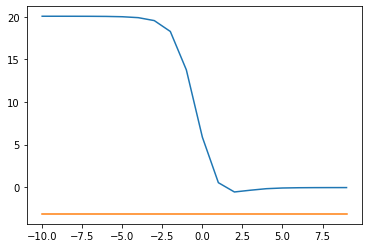

In [63]:
plt.plot(gl,eg)
#plt.plot(gl,eg_h)
plt.plot(gl,eT)

## Save Results

In [1068]:
import pickle
#fpath = "/Users/stenger/Documents/Research/Half_Classical_Evolution/Data/Job_id_test"

#file_to_store = open(fpath + "Gutz2_lagos_test.pickle", "wb")

#pickle.dump(results, file_to_store)

In [179]:
import pickle
fpath = "/Users/stenger/Documents/Research/Hubbard_symmetries/Gutzwiller/Data/Job_id_test"

file_to_read = open(fpath + "Gutz2_lagos_test.pickle", "rb")

loaded_results = pickle.load(file_to_read)

## Analyze 

In [72]:
pauli_meas = analyze_results(loaded_results,meas,labels)

In [102]:
k=1
d=0
N=4

H = Hs(k,d,N)
e,y = np.linalg.eig(H)
y = np.transpose(y)
arg = np.argsort(e)
e = np.sort(e)




eg = []
egh = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    egl = energy_from_results(loaded_results,g,k,d,N)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])
    expD = Gz(g,4)
    psi = Mdot([expD,psi_spin])
    psi = psi/np.sqrt(Mdot([np.conjugate(psi),psi]))
    egl = bkt(psi,H,psi)
    egh.append(egl)

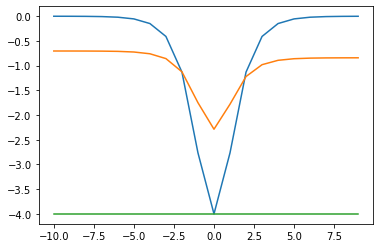

In [107]:
plt.plot(gl,egh)
plt.plot(gl,eg)
plt.plot(gl,eT)
#plt.ylim(-5,21)

In [180]:
loaded_results

[{'0000': 356,
  '0001': 407,
  '0010': 364,
  '0011': 513,
  '0100': 479,
  '0101': 674,
  '0110': 500,
  '0111': 405,
  '1000': 333,
  '1001': 483,
  '1010': 519,
  '1011': 630,
  '1100': 786,
  '1101': 657,
  '1110': 481,
  '1111': 605},
 {'0000': 503,
  '0001': 298,
  '0010': 290,
  '0011': 405,
  '0100': 522,
  '0101': 566,
  '0110': 463,
  '0111': 954,
  '1000': 512,
  '1001': 345,
  '1010': 342,
  '1011': 1093,
  '1100': 671,
  '1101': 613,
  '1110': 317,
  '1111': 298},
 {'0000': 355,
  '0001': 340,
  '0010': 747,
  '0011': 308,
  '0100': 265,
  '0101': 653,
  '0110': 402,
  '0111': 478,
  '1000': 414,
  '1001': 291,
  '1010': 1327,
  '1011': 403,
  '1100': 543,
  '1101': 652,
  '1110': 430,
  '1111': 584},
 {'0000': 274,
  '0001': 322,
  '0010': 282,
  '0011': 299,
  '0100': 721,
  '0101': 475,
  '0110': 813,
  '0111': 342,
  '1000': 434,
  '1001': 456,
  '1010': 945,
  '1011': 676,
  '1100': 651,
  '1101': 394,
  '1110': 817,
  '1111': 291},
 {'0000': 1060,
  '0001': 295,
  '